## Initializations.

In [6]:
# Save how much memory is used by OS and not available for script.
import psutil
MB_UNIT = 1024**2
OS_MEM = (psutil.virtual_memory().used)


from shared.preface import *
import shared.functions as fct

# --------------------------------- #
# Find starting IDs for halo batch. #
# --------------------------------- #

# Initialize parameters and files.
PRE_BOX = PRE(
    sim='L025N752', 
    z0_snap=36, z4_snap=13, DM_lim=10000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=10, thetas=10, vels=100,
    pre_CPUs=128, sim_CPUs=128, mem_lim_GB=224
)

TEMP_DIR = f'XB_tests'

********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 10, THETAs=10, Vs=100
Total neutrinos: 10000
# Simulation parameters:
Simulation box: L025N752
Snapshot from 0036 (z=0) to 0013 (z=4)
Pre/Sim CPUs 128/128
DM limit for cells: 10000
DM mass of sim box in log10 Msun: 6.1577
Smoothening length of sim box in kpc: 0.65
# File management:
Box files directory: 
 /projects/0/einf180/Tango_sims/L025N752/DMONLY/SigmaConstant00
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/L025N752/DMONLY/SigmaConstant00
**********************************************************


## Precalculations (run once: saved in XB_tests folder).

In [2]:
# ======================================= #
# Run precalculations for benchmark halo. #
# ======================================= #

# Create empty arrays to save specifics of each loop.
snaps_GRID_L = np.zeros(len(PRE_BOX.NUMS_SNAPS))
snaps_DM_num = np.zeros(len(PRE_BOX.NUMS_SNAPS))
save_QJ_abs = []

for j, snap in enumerate(PRE_BOX.NUMS_SNAPS[::-1]):
    
    print(f'benchmark halo ; snapshot {snap}')

    # ------------------ #
    # Load DM positions. #
    # ------------------ #
    IDname = f'benchmark_halo_snap_{snap}'
    DM_raw = np.load(f'{PRE_BOX.OUT_DIR}/{IDname}.npy')
    DM_particles = len(DM_raw)


    # ---------------------- #
    # Cell division process. #
    # ---------------------- #

    # Initialize grid.
    snap_GRID_L = (int(np.abs(DM_raw).max()) + 1)*kpc
    raw_grid = fct.grid_3D(snap_GRID_L, snap_GRID_L)
    init_grid = np.expand_dims(raw_grid, axis=1)

    # Prepare arrays for cell division.
    DM_raw *= kpc
    DM_pos = np.expand_dims(DM_raw, axis=0)
    DM_pos_for_cell_division = np.repeat(DM_pos, len(init_grid), axis=0)

    
    ### Interlude: Calculate QJ_aa and QJ_ab for complete halo. ###
    
    # Center all DM particles of halo on c.o.m. of halo and get distances.
    # DM_raw -= DM_com  #note: assume DM_com is center.
    DM_raw_dis = np.expand_dims(np.sqrt(np.sum(DM_raw**2, axis=1)), axis=1)

    # Permute order of coords by one, i.e. (x,y,z) -> (z,x,y).
    DM_raw_roll = np.roll(DM_raw, 1)

    # Terms appearing in the quadrupole term.
    QJ_aa = np.sum(3*DM_raw**2 - DM_raw_dis**2, axis=0)
    QJ_ab = np.sum(3*DM_raw*DM_raw_roll, axis=0)
    del DM_raw
    save_QJ_abs.append(np.array([QJ_aa, QJ_ab]))


    # Cell division.
    cell_division_count = fct.cell_division(
        init_grid, DM_pos_for_cell_division, snap_GRID_L, PRE_BOX.DM_LIM, None, TEMP_DIR, IDname
    )
    del DM_pos_for_cell_division

    # Load files from cell division.
    fin_grid = np.load(f'{TEMP_DIR}/fin_grid_{IDname}.npy')
    DM_count = np.load(f'{TEMP_DIR}/DM_count_{IDname}.npy')
    cell_com = np.load(f'{TEMP_DIR}/cell_com_{IDname}.npy')
    cell_gen = np.load(f'{TEMP_DIR}/cell_gen_{IDname}.npy')
    
    # Save snapshot specific parameters.
    snaps_GRID_L[j] = snap_GRID_L
    snaps_DM_num[j] = np.sum(DM_count)


    # --------------------------------------------- #
    # Calculate gravity grid (in batches of cells). #
    # --------------------------------------------- #
    cell_coords = np.squeeze(fin_grid, axis=1)
    cells = len(cell_coords)


    # -------------------- #
    # Short-range gravity. #
    # -------------------- #

    # Calculate available memory per core.
    mem_so_far = (psutil.virtual_memory().used - OS_MEM)/MB_UNIT
    mem_left = PRE_BOX.MEM_LIM_GB*1e3 - mem_so_far
    core_mem_MB = mem_left / PRE_BOX.PRE_CPUs

    # Determine short-range chuncksize based on available memory and cells.
    chunksize_sr = fct.chunksize_short_range(
        cells, DM_particles, PRE_BOX.DM_LIM*SHELL_MULTIPLIERS[-1], core_mem_MB
    )

    # Split workload into batches (if necessary).
    batch_arr, cell_chunks, cgen_chunks = fct.batch_generators_short_range(
        cell_coords, cell_gen, chunksize_sr
    )

    with ProcessPoolExecutor(PRE_BOX.PRE_CPUs) as ex:
        ex.map(
            fct.cell_gravity_short_range, 
            cell_chunks, cgen_chunks, repeat(snap_GRID_L), 
            repeat(DM_pos), repeat(PRE_BOX.DM_LIM), repeat(PRE_BOX.DM_SIM_MASS), 
            repeat(PRE_BOX.SMOOTH_L), repeat(TEMP_DIR), batch_arr, 
            repeat(chunksize_sr)
        )

    # Combine short-range batch files.
    dPsi_short_range_batches = [
        np.load(f'{TEMP_DIR}/batch{b}_short_range.npy') for b in batch_arr
    ]
    dPsi_short_range = np.array(
        list(chain.from_iterable(dPsi_short_range_batches))
    )

    # Combine DM_in_cell_IDs batches (needed for long-range gravity).
    DM_in_cell_IDs_l = []
    for b_id in batch_arr:
        DM_in_cell_IDs_l.append(
            np.load(f'{TEMP_DIR}/batch{b_id}_DM_in_cell_IDs.npy')
        )
    DM_in_cell_IDs_np = np.array(
        list(chain.from_iterable(DM_in_cell_IDs_l)))
    np.save(f'{TEMP_DIR}/DM_in_cell_IDs_{IDname}.npy', DM_in_cell_IDs_np)
    

    # ------------------- #
    # Long-range gravity. #
    # ------------------- #
    
    # Calculate available memory per core.
    mem_so_far = (psutil.virtual_memory().used - OS_MEM)/MB_UNIT
    mem_left = PRE_BOX.MEM_LIM_GB*1e3 - mem_so_far
    core_mem_MB = mem_left / PRE_BOX.PRE_CPUs

    # Determine long-range chuncksize based on available memory and cells.
    # chunksize_lr = chunksize_long_range(cells, core_mem_MB)
    chunksize_lr = 501

    # Split workload into batches (if necessary).
    DM_in_cell_IDs = np.load(f'{TEMP_DIR}/DM_in_cell_IDs_{IDname}.npy')
    batch_IDs, cellC_rep, cellC_cc, gen_rep, cib_IDs_gens, count_gens, com_gens, gen_gens = fct.batch_generators_long_range(
        cell_coords, cell_com, cell_gen, DM_count, chunksize_lr
    )

    with ProcessPoolExecutor(PRE_BOX.PRE_CPUs) as ex:
        ex.map(
            fct.cell_gravity_long_range_quadrupole, 
            cellC_rep, cib_IDs_gens, batch_IDs, 
            cellC_cc, com_gens, gen_gens, repeat(snap_GRID_L),
            repeat(np.squeeze(DM_pos, axis=0)), count_gens, 
            repeat(DM_in_cell_IDs), repeat(PRE_BOX.DM_SIM_MASS), 
            repeat(TEMP_DIR), repeat(chunksize_lr), gen_rep
        )

    # Combine long-range batch files.
    c_labels = np.unique(cellC_rep)
    b_labels = np.unique(batch_IDs)
    with ProcessPoolExecutor(PRE_BOX.PRE_CPUs) as ex:
        ex.map(
            fct.load_dPsi_long_range, c_labels, 
            repeat(b_labels), repeat(TEMP_DIR)
        )

    dPsi_long_range = np.array(
        [np.load(f'{TEMP_DIR}/cell{c}_long_range.npy') for c in c_labels])

    # Combine short- and long-range forces.
    dPsi_grid = dPsi_short_range + dPsi_long_range
    np.save(f'{TEMP_DIR}/dPsi_grid_{IDname}.npy', dPsi_grid)

benchmark halo ; snapshot 0036
benchmark halo ; snapshot 0035
benchmark halo ; snapshot 0034
benchmark halo ; snapshot 0033
benchmark halo ; snapshot 0032
benchmark halo ; snapshot 0031
benchmark halo ; snapshot 0030
benchmark halo ; snapshot 0029
benchmark halo ; snapshot 0028
benchmark halo ; snapshot 0027
benchmark halo ; snapshot 0026
benchmark halo ; snapshot 0025
benchmark halo ; snapshot 0024
benchmark halo ; snapshot 0023
benchmark halo ; snapshot 0022
benchmark halo ; snapshot 0021
benchmark halo ; snapshot 0020
benchmark halo ; snapshot 0019
benchmark halo ; snapshot 0018
benchmark halo ; snapshot 0017
benchmark halo ; snapshot 0016
benchmark halo ; snapshot 0015
benchmark halo ; snapshot 0014
benchmark halo ; snapshot 0013


## Simulation.

In [4]:
def EOMs(s_val, y):

    # Initialize vector.
    x_i, u_i = np.reshape(y, (2,3))

    # Switch to "numerical reality" here.
    x_i *= kpc
    u_i *= (kpc/s)

    # Find z corresponding to s via interpolation.
    z = np.interp(s_val, S_STEPS, ZEDS)

    # Snapshot specific parameters.
    idx = np.abs(PRE_BOX.ZEDS_SNAPS - z).argmin()
    snap = PRE_BOX.NUMS_SNAPS[idx]
    snap_GRID_L = snaps_GRID_L[idx]

    # Neutrino inside cell grid.
    if np.all(np.abs(x_i)) <= snap_GRID_L:

        # Find which (pre-calculated) derivative grid to use at current z.
        simname = f'benchmark_halo_snap_{snap}'
        dPsi_grid = fct.load_grid(TEMP_DIR, 'derivatives', simname)
        cell_grid = fct.load_grid(TEMP_DIR, 'positions',   simname)

        cell_idx = fct.nu_in_which_cell(x_i, cell_grid)  # index of cell
        grad_tot = dPsi_grid[cell_idx,:]                 # derivative of cell

    # Neutrino outside cell grid.
    else:
        # NrDM = snaps_DM_num[idx]
        # grad_tot = fct.outside_gravity(x_i, NrDM, PRE_BOX.DM_SIM_MASS)

        # With quadrupole.
        DM_com = np.zeros_like(x_i)
        DM_num = snaps_DM_num[idx]
        QJ_abs = save_QJ_abs[idx]
        grad_tot = fct.outside_gravity_quadrupole(
            x_i, DM_com, PRE_BOX.DM_SIM_MASS, DM_num, QJ_abs
        )

    # Switch to "physical reality" here.
    grad_tot /= (kpc/s**2)
    x_i /= kpc
    u_i /= (kpc/s)

    # Hamilton eqns. for integration (global minus, s.t. we go back in time).
    dyds = -np.array([
        u_i, 1./(1.+z)**2 * grad_tot
    ])

    return dyds


def backtrack_1_neutrino(y0_Nr):
    """Simulate trajectory of 1 neutrino."""

    # Split input into initial vector and neutrino number.
    y0, Nr = y0_Nr[0:-1], y0_Nr[-1]

    # Solve all 6 EOMs.
    sol = solve_ivp(
        fun=EOMs, t_span=[S_STEPS[0], S_STEPS[-1]], t_eval=S_STEPS,
        y0=y0, method=SOLVER, vectorized=True,
        args=()
        )
    
    np.save(f'{TEMP_DIR}/nu_{int(Nr)}.npy', np.array(sol.y.T))


# Display parameters for simulation.
print(f'***Running simulation with {PRE_BOX.NUS} neutrinos.***')
print(f'benchmark halo, CPUs={PRE_BOX.SIM_CPUs}')

start = time.perf_counter()

# Draw initial velocities.
ui = fct.init_velocities(PRE_BOX.PHIs, PRE_BOX.THETAs, PRE_BOX.MOMENTA)

# Combine vectors and append neutrino particle number.
y0_Nr = np.array(
    [np.concatenate((X_SUN, ui[i], [i+1])) for i in range(PRE_BOX.NUS)]
    )

# Run simulation on multiple cores.
with ProcessPoolExecutor(PRE_BOX.SIM_CPUs) as ex:
    ex.map(backtrack_1_neutrino, y0_Nr)


# Compactify all neutrino vectors into 1 file.
Ns = np.arange(PRE_BOX.NUS, dtype=int)            
nus = [np.load(f'{TEMP_DIR}/nu_{Nr+1}.npy') for Nr in Ns]
Bname = f'{PRE_BOX.NUS}nus_benchmark_halo'
np.save(f'{TEMP_DIR}/{Bname}.npy', np.array(nus))

# Calculate local overdensity.
vels = fct.load_sim_data(TEMP_DIR, Bname, 'velocities')
poss = fct.load_sim_data(TEMP_DIR, Bname, 'positions')

# note: (optional) save velocities, such that we can do additional plots
np.save(f'{PRE_BOX.OUT_DIR}/velocities_{Bname}.npy', np.array(vels))
np.save(f'{PRE_BOX.OUT_DIR}/positions_{Bname}.npy', np.array(poss))

#! The final number density must **NOT** be stored in the temporary folder.
out_file = f'{PRE_BOX.OUT_DIR}/number_densities_band_jupyter_{Bname}.npy'
fct.number_densities_mass_range(
    vels, NU_MRANGE, out_file
)

# Now delete velocities and distances.
fct.delete_temp_data(f'{TEMP_DIR}/{Bname}.npy')


seconds = time.perf_counter()-start
minutes = seconds/60.
hours = minutes/60.
print(f'Sim time min/h: {minutes} min, {hours} h.')

# # Remove temporary folder with all individual neutrino files.
# shutil.rmtree(TEMP_DIR)

***Running simulation with 10000 neutrinos.***
benchmark halo, CPUs=128
Sim time min/h: 3.3150220948834126 min, 0.055250368248056875 h.
Total time: 21.94121789885006 min, 0.3656869649808343 h.


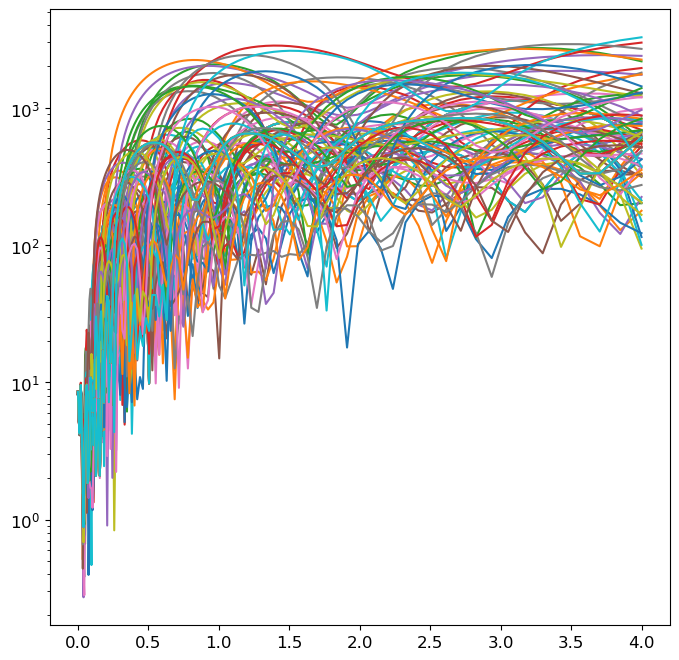

In [14]:
for pos in poss[::100]:
    r = np.sqrt(np.sum(pos**2, axis=1))
    plt.semilogy(ZEDS, r)
plt.show()

## Figure of Merit: Number density band.

********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 10, THETAs=10, Vs=100
Total neutrinos: 10000
# Simulation parameters:
Simulation box: LinfNinf
Sim CPUs 128
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/LinfNinf
Halos in smooth sim: MW
**********************************************************


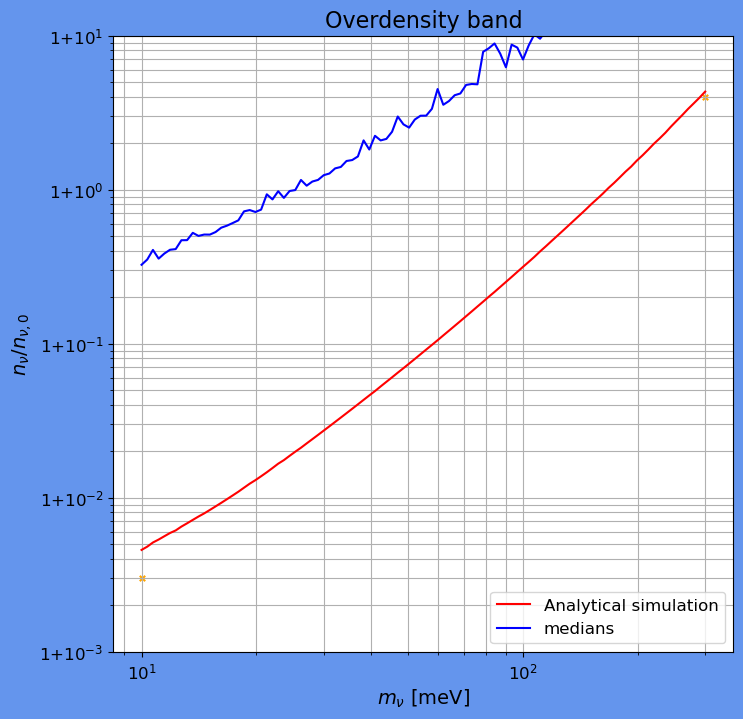

In [7]:
from shared.preface import *
import shared.functions as fct

# Load data for MW halo only of smooth simulation.
PRE_SMOOTH = PRE(
    sim='LinfNinf', phis=10, thetas=10, vels=100,
    sim_CPUs=128, MW_HALO=True, VC_HALO=False
)

smooth_name = f'{PRE_SMOOTH.NUS}nus_smooth_{PRE_SMOOTH.HALOS}_{SOLVER}'
smooth_dir = f'{os.getcwd()}/{PRE_SMOOTH.SIM}'
u_all_MW = fct.load_sim_data(smooth_dir, smooth_name, 'velocities')

smooth_output = f'{smooth_dir}/number_densities_{smooth_name}.npy'

fct.number_densities_mass_range(
    u_all_MW, NU_MRANGE, smooth_output, 
    average=False, m_start=0.01, z_start=0.5
)
etas_smooth = np.load(f'{smooth_output}')/N0


# Benchmark Halo.
bench_name = f'{PRE_BOX.NUS}nus_benchmark_halo'
out_file = f'{PRE_BOX.OUT_DIR}/number_densities_band_jupyter_{bench_name}.npy'
etas_bench = np.load(f'{out_file}')/N0

fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fname = f'{splits[0]}_{splits[1]}_{bench_name}'
fct.plot_eta_band(etas_bench, etas_smooth, NU_MRANGE, fig_dir, fname, show=True, Mertsch=True)#, BenchHaloEtas=etas_bench, ylims=(1e-3, 1e2))


## More Plotting.

In [ ]:
u_all = np.load(f'{PRE_BOX.OUT_DIR}/velocities_{Bname}.npy')

fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fname = f'{splits[0]}_{splits[1]}_{hname}'
fct.plot_eta_z_back_1Halo(u_all, NU_MASSES, fig_dir, fname, show=True)

fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fname = f'{splits[0]}_{splits[1]}_{hname}'
fct.plot_phase_space_1Halo(
    u_all, NU_MASSES, halo_batch_params[0], 
    PRE_BOX.Vs, PRE_BOX.PHIs, PRE_BOX.THETAs, PRE_BOX.LOWER, PRE_BOX.UPPER,
    fig_dir, fname, show=True, curtain=True
)

fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fname = f'{splits[0]}_{splits[1]}_{hname}'
fct.plot_number_density_integral(
    u_all, NU_MASSES, 
    PRE_BOX.Vs, PRE_BOX.PHIs, PRE_BOX.THETAs, PRE_BOX.LOWER, PRE_BOX.UPPER,
    fig_dir, fname, show=True, curtain=True
)

In [ ]:
def plot_velocities_and_distances(
    out_dir, fname, Rvir, fig_dir, fig_name, batches=False, show=False
):

    # Load positions and velocities.
    vel = fct.load_sim_data(out_dir, fname, 'velocities')
    pos = fct.load_sim_data(out_dir, fname, 'positions')

    # Magnitudes of velocities and radial distances from halo center.
    mag = np.sqrt(np.sum(vel**2, axis=2))
    dis = np.sqrt(np.sum(pos**2, axis=2))

    # Sort arrays from low to high velocity neutrinos.
    ids = mag[:,0].argsort()
    ids_2D = np.repeat(np.expand_dims(ids, axis=1), mag.shape[1], axis=1)
    u_unit = (kpc/s)/(km/s)
    mag_sort = np.take_along_axis(mag, ids_2D, axis=0)*u_unit
    dis_sort = np.take_along_axis(dis, ids_2D, axis=0)

    # Special velocity markers.
    v_start = mag_sort[:,0]
    v_max = v_start.max()
    v_esc = mag_sort[np.where(v_start <= 550)]

    # Velocity batches.
    v1 = mag_sort[np.where(v_start <= v_max/4)]
    v2 = mag_sort[np.where((v_max/4 < v_start) & (v_start <= v_max/2))]
    v3 = mag_sort[np.where((v_max/2 < v_start) & (v_start <= v_max*3/4))]
    v4 = mag_sort[np.where(v_max*3/4 < v_start)]

    # Corresponding distance batches.
    d1 = dis_sort[:len(v1),:]
    d2 = dis_sort[len(v1):len(v1)+len(v2),:]
    d3 = dis_sort[len(v1)+len(v2):len(v1)+len(v2)+len(v3),:]
    d4 = dis_sort[len(v1)+len(v2)+len(v3):,:]
    # d_esc = dis_sort[:v_esc.shape[0],:]


    # Plotting.
    fig, ax = plt.subplots(1,1)

    if batches:
        for i, d in enumerate((d1,d2,d3,d4)):
            print(d.shape, d[0,0], d[0,-1])
            y_vals = np.median(d, axis=0)
            ax.semilogy(ZEDS, y_vals, alpha=0.7, label=f'batch {i} mean')
    else:
        d_show = dis_sort[:3000,:][::300]   #! lowest velocities
        # d_show = dis_sort[3000:,:][::1000]  #! highest velocities
        for d in d_show:
            ax.semilogy(ZEDS, d)

    ax.axhline(Rvir, c='r', ls=':', label='R_vir of halo')
    # ax[j].set_xlim(-0.01,1)
    ax.legend()
    ax.set_ylabel('distance to halo center (kpc)')
    ax.set_xlabel('redshift')

    fig_out = f'{fig_dir}/distance_from_origin_{fig_name}.pdf'
    plt.savefig(
        fig_out, facecolor=fig.get_facecolor(), edgecolor='none', 
        bbox_inches='tight'
    )
    if show:
        plt.show()
    else:
        plt.close()



# Discrete simulation.
halo_j = 0
tot_name = f'{hname}_halo{halo_j}'
fname = f'{PRE_BOX.NUS}nus_{tot_name}'
Rvir = halo_batch_params[halo_j, 0]

fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fig_name = f'{splits[0]}_{splits[1]}_{hname}'

plot_velocities_and_distances(PRE_BOX.OUT_DIR, fname, Rvir, fig_dir, fig_name, batches=False, show=True)